<a href="https://colab.research.google.com/github/ptats/ml101-grad-workshop/blob/master/notebooks/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Create your own image classifier - including the dataset**

by: Paula Tattam. An extraction of Fastai [Lesson 1](https://https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb) and [Lesson 2](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb)

In this workshop you will get to create your own image classification dataset using google images. You will then build and train your own image classifier using the [fastai V1 library](https://www.fast.ai/2018/10/02/fastai-ai/). fastai is a python machine learning library built on top of the popular [PyTorch v1.0](https://engineering.fb.com/ai-research/facebook-accelerates-ai-development-with-new-partners-and-production-capabilities-for-pytorch-1-0/) machine learning framework.

Fastai is a library that allows you to rapidly build and train your own  machine learning models utilising transfer learning from a range of current state of the art models.

See setup instructions for google collab [here.]()

In [0]:
# run once
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My\ Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from fastai.vision import *

# **Step 1: Pick a classification task**
For step 1 make up an image classification task. It can be any topic of your choice but the images will need to be available through [google images.](https://images.google.com/?gws_rd=ssl) For example:

*   Disney character classifier
*   Hotdogs or legs
*   Big cat classifier (tigers, lions, cheetahs, etc...)

Please try keep it PG and don't pick too many different classes as you will need to repeat the below step for each class.

Google image search allows you to exclude certain words in a search, combine searchs and a number of other operations.

For example, to search dog but exlcude wolves, use the `-` operator:

`dog -wolf`

See more options [here](https://support.google.com/websearch/answer/2466433?visit_id=637175902163553047-3698874010&p=adv_operators&hl=en&rd=1).






# **Step 2: Download URLs**

Now you will need to download each image URL to a file. This can be done by using a small snippet of JavaScript. You will need to open the javascript console which can be done as follows:

* Chrome: `ctrl+shift+j` (macOS: `Cmd+Opt+j`)
* Firefox: `ctrl+shit+k` (macOS: `Cmd+Opt+k`)

This will open up a window where you will paste the below code snippet. Before you paste the below code, scroll down in your search results window a few times to load images. Only the displayed search image urls will be copied.

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

Repeat this step for each classification category that you have chosen. Once the file is downloaded, rename as per the following convention:

`urls_<label>.csv`

# **Step 3: Create directories and upload files**

Choose an appropriate name for your directory and create a list of your class labels. Edit the below cells as noted and run.



In [0]:
# UPDATE ME: add your labels as per the label used for the csv file
labels = ["zoro", "sanji", "nami", "brook", "robin", "chopper", "frankie", "luffy", "usopp"] 

In [0]:
# UPDATE ME: name as per your classifcation task
name = "one_piece_crew"

In [0]:
for label in labels:
  path = Path(f'data/{name}') 
  dest = path/label
  dest.mkdir(parents=True, exist_ok=True)

In [46]:
path.ls()

[PosixPath('data/one_piece_crew/urls_usopp.csv'),
 PosixPath('data/one_piece_crew/robin'),
 PosixPath('data/one_piece_crew/sanji'),
 PosixPath('data/one_piece_crew/frankie'),
 PosixPath('data/one_piece_crew/urls_nami.csv'),
 PosixPath('data/one_piece_crew/urls_chopper.csv'),
 PosixPath('data/one_piece_crew/urls_robin.csv'),
 PosixPath('data/one_piece_crew/luffy'),
 PosixPath('data/one_piece_crew/.ipynb_checkpoints'),
 PosixPath('data/one_piece_crew/urls_zoro.csv'),
 PosixPath('data/one_piece_crew/urls_sanji.csv'),
 PosixPath('data/one_piece_crew/urls_brook.csv'),
 PosixPath('data/one_piece_crew/brook'),
 PosixPath('data/one_piece_crew/nami'),
 PosixPath('data/one_piece_crew/urls_frankie.csv'),
 PosixPath('data/one_piece_crew/usopp'),
 PosixPath('data/one_piece_crew/chopper'),
 PosixPath('data/one_piece_crew/urls_luffy.csv'),
 PosixPath('data/one_piece_crew/zoro'),
 PosixPath('data/one_piece_crew/models')]

Lastly, we upload the csv files. Open the side menu, press 'Upload' and select your files. 

![Upload Images](https://github.com/ptats/ml101-grad-workshop/tree/master/images)

# **Step 4: Download images**

Next you will need to download the images for each label. Luckily, fast.ai have a function specifically designed for this. All you need to specify are:

* The filename for file containing URls
* destination folder
* max number of images to download

In this example, we set the limit to 200.

In [47]:
for label in labels:
  filename = f"urls_{label}.csv"
  dest = path/label
  download_images(path/filename, dest, max_pics=200)

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Next, remove any images that cannot be opened.

In [48]:
for label in labels:
  print(label)
  verify_images(path/label, delete=True, max_size=500)

zoro


sanji


nami


brook


robin


chopper


frankie


luffy


usopp


# **Step 5: Data View**

Next you will create a `DataBunch`, an object that is used for model training in the fast.ai library. The databunch is unique in that as the images are loaded, all the required pre-processing is completed as well. This includes:

*   resizing
*   pixel normalisation
*   flipping, rotation, zoom
*   contrast changes
*   symmetric warping

Some of the default image transformations may not make sense depending on the application. For example, we would not flip an image of a cat vertically but for satellite imagery this would make sense.

For now don't worry too much about this as we will cover more on this later.

Once you create your databunch, you can inspect a batch of the data that has been uploaded and do a sanity check.

In [0]:
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [50]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['brook',
  'chopper',
  'frankie',
  'luffy',
  'nami',
  'robin',
  'sanji',
  'usopp',
  'zoro'],
 9,
 1440,
 360)

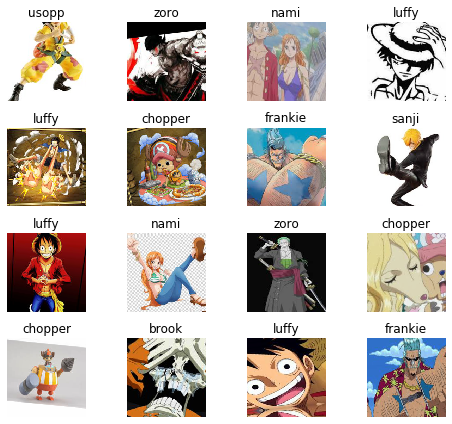

In [51]:
data.show_batch(rows=4, figsize=(7,6))

# **Step 6: Train Model**

With the data loaded and ready, you can now create your deep learning model. For this example, you will use a type of convolutional neural network called Resnet34. It will be explained later what a convolutional neural network is and at a very high level, what Resnet34 is. For now, understand that it is a very deep neural network that has special residual connections to improve learning.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [53]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [54]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.697863,1.234358,0.369444,00:15
1,1.805242,1.072869,0.311111,00:15
2,1.388259,1.016062,0.300000,00:15
3,1.133792,0.992592,0.286111,00:15


In [0]:
learn.save('stage-1')

# **Step 7: Fine tuning and learning rates**

Once your model is working as expected, you can now train some more. You will unfreeze the model, and train some more.

In [0]:
learn.unfreeze()

In [57]:
learn.lr_find(start_lr=1e-7, end_lr=1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


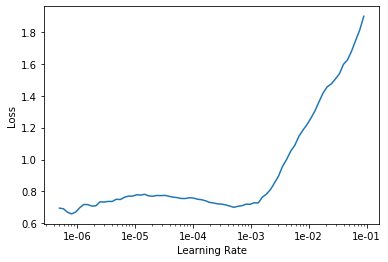

In [58]:
learn.recorder.plot()

In [59]:
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.740615,0.937208,0.269444,00:16
1,0.710257,0.910481,0.241667,00:16
2,0.656697,0.817187,0.216667,00:16
3,0.579543,0.812563,0.216667,00:16


In [0]:
learn.save('stage-2')

More experimentation

In [61]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1440 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
robin,robin,robin,robin,robin
Path: data/one_piece_crew;

Valid: LabelList (360 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
usopp,robin,usopp,brook,sanji
Path: data/one_piece_crew;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [62]:
learn.fit_one_cycle(10, max_lr=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.751603,0.983795,0.286111,00:16
1,0.747844,0.918849,0.247222,00:16
2,0.694242,0.898893,0.247222,00:15
3,0.592457,0.852109,0.213889,00:16
4,0.533497,0.898895,0.230556,00:16
5,0.454983,0.888224,0.219444,00:15
6,0.407778,0.865537,0.211111,00:16
7,0.348459,0.882849,0.211111,00:16
8,0.295697,0.865661,0.211111,00:16
9,0.275894,0.874317,0.213889,00:16


# **Step 7: Inspecting the Results**

Now you will inspect the results of your model. Here you will get to see:

*   Which categories the model confused with one another the most
*   Whether the misclassifications were reasonable or not

And lastly, you can view the confusion matrix to understand the distribution of errors the model makes.



In [28]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

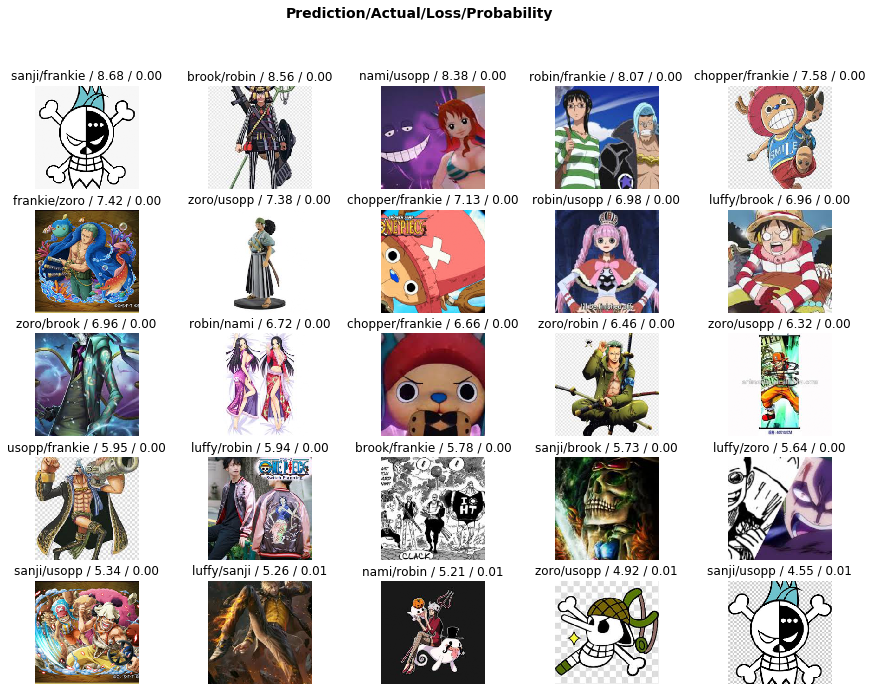

In [29]:
interp.plot_top_losses(25, figsize=(15,11))

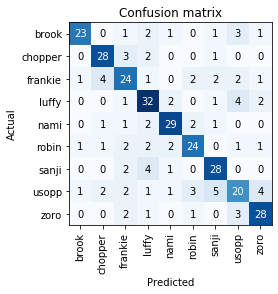

In [30]:
interp.plot_confusion_matrix()

In [31]:
interp.most_confused(min_val=2)

[('usopp', 'sanji', 5),
 ('frankie', 'chopper', 4),
 ('luffy', 'usopp', 4),
 ('sanji', 'luffy', 4),
 ('usopp', 'zoro', 4),
 ('brook', 'usopp', 3),
 ('chopper', 'frankie', 3),
 ('usopp', 'robin', 3),
 ('zoro', 'usopp', 3),
 ('brook', 'luffy', 2),
 ('chopper', 'luffy', 2),
 ('frankie', 'robin', 2),
 ('frankie', 'sanji', 2),
 ('frankie', 'usopp', 2),
 ('luffy', 'nami', 2),
 ('luffy', 'zoro', 2),
 ('nami', 'luffy', 2),
 ('nami', 'robin', 2),
 ('robin', 'frankie', 2),
 ('robin', 'luffy', 2),
 ('robin', 'nami', 2),
 ('sanji', 'frankie', 2),
 ('usopp', 'chopper', 2),
 ('usopp', 'frankie', 2),
 ('zoro', 'frankie', 2)]

# **Step 9: Data clean up**

Some of the top losses are not due to our model performing badly. Instead, they are due to incorrect images in our training data. fast.ai has a `ImageCleaner` widget that makes cleaning this kind of thing up super easy.

Unfortunately, this widget does not work with jupyter lab or google collab. Don't run the following lines of code. This will be demonstrated only.

In [0]:
from fastai.widgets import *

In [0]:
db = (ImageList.from_folder(path)
      .split_none()
      .label_from_folder()
      .transform(get_transforms(), size=224)
      .databunch())

In [61]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1620 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
robin,robin,robin,robin,robin
Path: data/one_peice_crew;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/one_peice_crew;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

In [62]:
ds, idx = DatasetFormatter().from_toplosses(learn_cln)

In [0]:
ImageCleaner(ds, idxs, path)